# Second run at the house price kaggle challenge

A medium ai approach at the kaggle house price prediction challenge. Following the approach laid out in the first few lessons of the fast.ai machine learning course

For the second approach we'll do some basic feature engineering and tuning of the Random Forest's hyperparameters

In [1]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split

import matplotlib as plt
#import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

### Configuring global variables 

In [2]:
train_path = './input/train.csv'
test_path = './input/test.csv'

In [3]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

### Load train & test data

At this stage not adding any special flags when loading the data. Considering the low file size (and I don't know how to do it) the data hasn't been converted to feather format

In [4]:
raw_df = pd.read_csv(train_path)
test_raw_df = pd.read_csv(test_path)

In [5]:
raw_df.shape, test_raw_df.shape

((1460, 81), (1459, 80))

In [6]:
raw_df.tail(10).T

,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
Id,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460
MSSubClass,90,20,180,20,20,60,20,70,20,20
MSZoning,RL,RL,RM,RL,FV,RL,RL,RL,RL,RL
LotFrontage,60,78,35,90,62,62,85,66,68,75
LotArea,9000,9262,3675,17217,7500,7917,13175,9042,9717,9937
Street,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,Pave,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub


### Handling null values in raw data

Since the plan is to use one hot encoding we need to remove null values from the data sets. By reviewiing the data it seems there are three simple options:

1. Drop feature
For features that have a large number of null values and don't appear to be important we can just remove them from the data set

2. Fill missing with mean
For continuous features we can simply take the mean value

3. Create 'missing' category
For categorical features we can create a value for missing data. This makes sense since a missing value make actually hold meaning, e.g. the property does not have a pool

In [7]:
null_features_count = raw_df.isnull().sum()
null_features_count = null_features_count[null_features_count > 0]
null_features_count

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

#### Test set difference 

We need to repeat the same process for the test set, i.e. make all the same transformations. 
In particular we need to see where the test set differs from the training set so that we don't miss transformations

In [8]:
test_null_features_count = test_raw_df.isnull().sum()
test_null_features_count = test_null_features_count[test_null_features_count > 0]

test_train_feature_diff = test_null_features_count.index.difference(null_features_count.index)
test_train_feature_diff.append(null_features_count.index.difference(test_null_features_count.index))

test_null_features_count[test_train_feature_diff]

BsmtFinSF1      1
BsmtFinSF2      1
BsmtFullBath    2
BsmtHalfBath    2
BsmtUnfSF       1
Exterior1st     1
Exterior2nd     1
Functional      2
GarageArea      1
GarageCars      1
KitchenQual     1
MSZoning        4
SaleType        1
TotalBsmtSF     1
Utilities       2
dtype: int64

In [9]:
# Created lists of feature names for missing values
large_null_features = [
    'MiscFeature'
]
fill_mean_features = [
    'MasVnrArea', 
    'GarageYrBlt', 
    'LotFrontage',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtFullBath',
    'BsmtHalfBath',
    'BsmtUnfSF',
    'GarageArea',
    'GarageCars',
    'TotalBsmtSF'
]
# this is only the test set at the minute, review the training set to see what can be switched
fill_most_common_cat_features = [
    'Exterior1st',
    'Exterior2nd',
    'Functional',
    'KitchenQual',
    'MSZoning',
    'SaleType',
    'Utilities' 
]
create_NA_cat_features = [
    'Alley',
    'PoolQC',
    'BsmtCond', 
    'BsmtFinType1', 
    'BsmtFinType2',
    'BsmtQual', 
    'BsmtExposure',
    'Fence',
    'FireplaceQu', 
    'GarageCond', 
    'GarageFinish', 
    'GarageQual',
    'GarageType'
]
create_none_cat_features = [
    'MasVnrType'
]

In [10]:
def handle_missing_values(df):
    for col in create_NA_cat_features:
        df[col].fillna(value='NA', inplace=True)

    for col in create_none_cat_features:
        df[col].fillna(value='None', inplace=True)

    for col in fill_mean_features:
        df[col].fillna(value=df[col].mean(), inplace=True)

    df.Electrical.fillna(value='Mix', inplace=True)

    df.drop(large_null_features, axis=1, inplace=True)
    
    for col in fill_most_common_cat_features:
        df[col].fillna(value=df[col].value_counts().idxmax(), inplace=True)

In [11]:
handle_missing_values(raw_df)
handle_missing_values(test_raw_df)

## Feature Engineering

The simplest start for this challenge is to add the Total Sq.F. feature, which is just the sum of the available area features.

In [12]:
raw_df['TotalSF'] = raw_df['GrLivArea'] + raw_df['TotalBsmtSF'] + raw_df['GarageArea'] + raw_df['EnclosedPorch'] + raw_df['ScreenPorch']
test_raw_df['TotalSF'] = test_raw_df['GrLivArea'] + test_raw_df['TotalBsmtSF'] + test_raw_df['GarageArea'] + test_raw_df['EnclosedPorch'] + test_raw_df['ScreenPorch']

### Create first model

Firstly we need to take the log of the Sale Price so that higher sale prices don't affect the model.

Then we will create a random forest with just the default values to see what score we can achieve

In [13]:
raw_df.SalePrice = np.log(raw_df.SalePrice)

In [14]:
one_hot_encoded_df = pd.get_dummies(data=raw_df)
test_one_hot_encoded_df = pd.get_dummies(data=test_raw_df)

#### Categories in train set that don't appear in test set

This is interesting, there are more features in the train set than the test set. This is caused by the one hot encoding. The training set must have categories that don't appear in the test set. I think the best way to handle this would be to use train_cats on the features, but I'll try that another time, and just drop the differences for now

In [15]:
one_hot_encoded_df.shape, test_one_hot_encoded_df.shape

((1460, 300), (1459, 282))

In [16]:
test_missing_features = one_hot_encoded_df.columns.difference(test_one_hot_encoded_df.columns)
test_missing_features = test_missing_features.delete(test_missing_features.get_loc('SalePrice'))
one_hot_encoded_df.drop(test_missing_features, axis=1, inplace=True)

In [17]:
one_hot_encoded_df.drop('SalePrice', axis=1, inplace=True)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_df, raw_df.SalePrice)

In [187]:
rf = RandomForestRegressor(n_estimators=1000, max_features=0.4)
rf.fit(X=X_train, y=y_train)
rf.score(X_test, y_test)

0.8998367489621302

In [188]:
y_pred = rf.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.1290928807324289

### Explore feature importance

In [177]:
feat_importance = pd.DataFrame({'cols': one_hot_encoded_df.columns, 'imp': rf.feature_importances_}).sort_values('imp', ascending=False)

In [178]:
feat_importance[:10]

,cols,imp
37,TotalSF,0.278151
4,OverallQual,0.192195
16,GrLivArea,0.123764
6,YearBuilt,0.070218
12,TotalBsmtSF,0.024238
161,ExterQual_TA,0.020363
7,YearRemodAdd,0.019097
26,GarageCars,0.017553
13,1stFlrSF,0.015494
27,GarageArea,0.015159


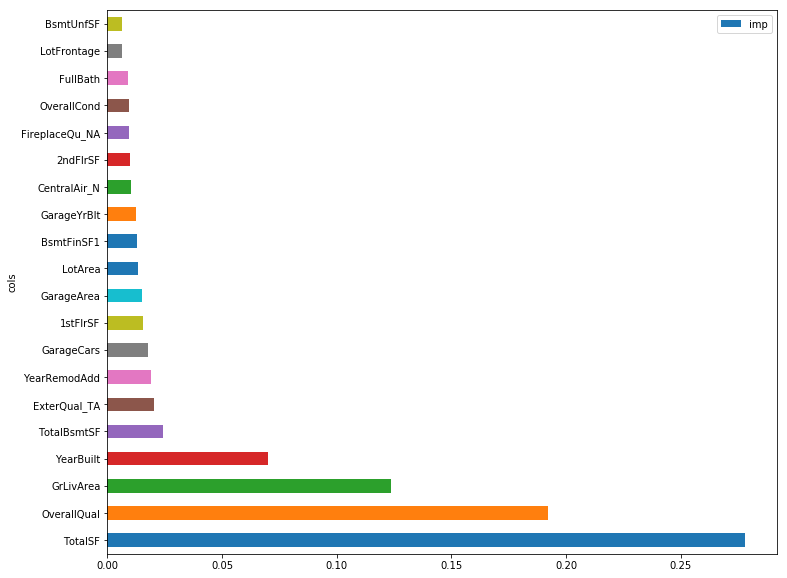

In [179]:
feat_importance[:20].plot('cols', 'imp', 'barh', figsize=(12,10))

### Create test set predictions for Kaggle

Create predictions from model for Kaggle submission 

In [24]:
def create_submission_df(model, test_data_df, test_data_ids):
    kaggle_preds = np.exp(model.predict(test_data_df))
    return pd.DataFrame({'Id': test_data_ids, 'SalePrice': kaggle_preds})

In [25]:
def save_submission_to_csv(submission, filename):
    submission.to_csv(filename,index=False)
    print('Saved file: ' + filename)

In [26]:
submission = create_submission_df(rf, test_one_hot_encoded_df, test_raw_df.Id)
#save_submission_to_csv(submission, 'Housing Predictions 2.csv')

Saved file: Housing Predictions 2.csv
